In [1]:
#IUPRED2

import sys
import textwrap
import math
import os


def avg(lst):
    return sum(lst) / len(lst)


def aa_freq(_seq):
    _freq = {}
    for _aa in _seq:
        if _aa in _freq:
            _freq[_aa] += 1
        else:
            _freq[_aa] = 1
    for _aa, _ins in _freq.items():
        _freq[_aa] = _ins / len(_seq)
    return _freq


def read_matrix(matrix_file):
    _mtx = {}
    with open(matrix_file, "r") as _fhm:
        for _line in _fhm:
            if _line.split()[0] in _mtx:
                _mtx[_line.split()[0]][_line.split()[1]] = float(_line.split()[2])
            else:
                _mtx[_line.split()[0]] = {}
                _mtx[_line.split()[0]][_line.split()[1]] = float(_line.split()[2])
    return _mtx


def read_histo(histo_file):
    hist = []
    h_min = float("inf")
    h_max = -float("inf")
    with open(histo_file, "r") as fnh:
        for _line in fnh:
            if _line.startswith("#"):
                continue
            if float(_line.split()[1]) < h_min:
                h_min = float(_line.split()[1])
            if float(_line.split()[1]) > h_max:
                h_max = float(_line.split()[1])
            hist.append(float(_line.split()[-1]))
    h_step = (h_max - h_min) / (len(hist))
    return hist, h_min, h_max, h_step


def smooth(energy_list, window):
    weighted_energy_score = [0] * len(energy_list)
    for idx in range(len(energy_list)):
        weighted_energy_score[idx] = avg(energy_list[max(0, idx - window):min(len(energy_list), idx + window + 1)])
    return weighted_energy_score


def read_seq(fasta_file):
    _seq = ""
    with open(fasta_file) as file_handler:
        for _line in file_handler:
            if _line.startswith(">"):
                continue
            _seq += _line.strip()
    return _seq


def iupred(seq, mode):
    if mode == "short":
        lc = 1
        uc = 25
        wc = 10
        mtx = read_matrix("{}/data/iupred2_short_energy_matrix".format(PATH))
        histo, histo_min, histo_max, histo_step = read_histo("{}/data/short_histogram".format(PATH))

    elif mode == 'glob':
        lc = 1
        uc = 100
        wc = 15
        mtx = read_matrix("{}/data/iupred2_long_energy_matrix".format(PATH))
        histo, histo_min, histo_max, histo_step = read_histo("{}/data/long_histogram".format(PATH))

        
#EDIT HERE: INSERT CORRECT PATH TO DATA FOLDER

    else:
        lc = 1
        uc = 100
        wc = 10
        mtx = read_matrix("{}/iupred2_long_energy_matrix".format('/Users/Parker/Desktop/Coding'))
        histo, histo_min, histo_max, histo_step = read_histo("{}/long_histogram".format('/Users/Parker/Desktop/Coding'))

    unweighted_energy_score = [0] * len(seq)
    weighted_energy_score = [0] * len(seq)
    iupred_score = [0] * len(seq)

    for idx in range(len(seq)):
        freq_dct = aa_freq(seq[max(0, idx - uc):max(0, idx - lc)] + seq[idx + lc + 1:idx + uc + 1])
        for aa, freq in freq_dct.items():
            try:
                unweighted_energy_score[idx] += mtx[seq[idx]][aa] * freq
            except KeyError:
                unweighted_energy_score[idx] += 0

    if mode == 'short':
        for idx in range(len(seq)):
            for idx2 in range(idx - wc, idx + wc + 1):
                if idx2 < 0 or idx2 >= len(seq):
                    weighted_energy_score[idx] += -1.26
                else:
                    weighted_energy_score[idx] += unweighted_energy_score[idx2]
            weighted_energy_score[idx] /= len(range(idx - wc, idx + wc + 1))
    else:
        weighted_energy_score = smooth(unweighted_energy_score, wc)

    glob_text = ""
    if mode == 'glob':
        gr = []
        in_gr = False
        beg, end = 0, 0
        for idx, val in enumerate(weighted_energy_score):
            if in_gr and val <= 0.3:
                gr.append({0: beg, 1: end})
                in_gr = False
            elif in_gr:
                end += 1
            if val > 0.3 and not in_gr:
                beg = idx
                end = idx
                in_gr = True
        if in_gr:
            gr.append({0: beg, 1: end})
        mgr = []
        k = 0
        kk = k + 1
        if gr:
            beg = gr[0][0]
            end = gr[0][1]
        nr = len(gr)
        while k < nr:
            if kk < nr and gr[kk][0] - end < 45:
                beg = gr[k][0]
                end = gr[kk][1]
                kk += 1
            elif end - beg + 1 < 35:
                k += 1
                if k < nr:
                    beg = gr[k][0]
                    end = gr[k][1]
            else:
                mgr.append({0: beg, 1: end})
                k = kk
                kk += 1
                if k < nr:
                    beg = gr[k][0]
                    end = gr[k][1]
        seq = seq.lower()
        nr = 0
        res = ""
        for i in mgr:
            res += seq[nr:i[0]] + seq[i[0]:i[1] + 1].upper()
            nr = i[1] + 1
        res += seq[nr:]
        res = " ".join([res[i:i + 10] for i in range(0, len(res), 10)])
        glob_text += "Number of globular domains: {}\n".format(len(mgr))
        for n, i in enumerate(mgr):
            glob_text += "          globular domain   {}.\t{}-{}\n".format(n + 1, i[0] + 1, i[1] + 1)
        glob_text += "\n".join(textwrap.wrap(res, 70))

    for idx, val in enumerate(weighted_energy_score):
        if val <= histo_min + 2 * histo_step:
            iupred_score[idx] = 1
        elif val >= histo_max - 2 * histo_step:
            iupred_score[idx] = 0
        else:
            iupred_score[idx] = histo[int((weighted_energy_score[idx] - histo_min) * (1 / histo_step))]
    return iupred_score, glob_text


def anchor2(seq, iupred_scores):
    local_window_size = 41
    iupred_window_size = 30
    local_smoothing_window = 5
    par_a = 0.0013
    par_b = 0.26
    par_c = 0.43
    iupred_limit = par_c - (par_a / par_b)
    mtx = read_matrix('{}/data/anchor2_energy_matrix'.format(PATH))
    interface_comp = {}
    with open('{}/data/anchor2_interface_comp'.format(PATH)) as _fn:
        for line in _fn:
            interface_comp[line.split()[1]] = float(line.split()[2])
    local_energy_score = [0] * len(seq)
    interface_energy_score = [0] * len(seq)
    energy_gain = [0] * len(seq)
    for idx in range(len(seq)):
        freq_dct = aa_freq(seq[max(0, idx - local_window_size):max(0, idx - 1)] + seq[idx + 2:idx + local_window_size + 1])
        for aa, freq in freq_dct.items():
            try:
                local_energy_score[idx] += mtx[seq[idx]][aa] * freq
            except KeyError:
                local_energy_score[idx] += 0
        for aa, freq in interface_comp.items():
            try:
                interface_energy_score[idx] += mtx[seq[idx]][aa] * freq
            except KeyError:
                interface_energy_score[idx] += 0
        energy_gain[idx] = local_energy_score[idx] - interface_energy_score[idx]
    iupred_scores = smooth(iupred_scores, iupred_window_size)
    energy_gain = smooth(smooth(energy_gain, local_smoothing_window), local_smoothing_window)
    anchor_score = [0] * len(seq)
    for idx in range(len(seq)):
        sign = 1
        if energy_gain[idx] < par_b and iupred_scores[idx] < par_c:
            sign = -1
        corr = 0
        if iupred_scores[idx] > iupred_limit and energy_gain[idx] < 0:
            corr = (par_a / (iupred_scores[idx] - par_c)) + par_b
        anchor_score[idx] = sign * (energy_gain[idx] + corr - par_b) * (iupred_scores[idx] - par_c)
        anchor_score[idx] = 1 / (1 + math.e ** (-22.97968 * (anchor_score[idx] - 0.0116)))
    return anchor_score

In [2]:
#Parses proteome in .fasta format into individual .fasta files

if 'Parsed_Proteome' not in os.listdir():
    os.mkdir('Parsed_Proteome')
if 'Disorder_Predictions' not in os.listdir():
    os.mkdir('Disorder_Predictions')
    
file2 = open('Proteome/UP000000803_7227.fasta', 'r')
string = ''



for line in file2:
    if line.startswith('>'):
        iterfile = '{0}.fasta'.format(line[4:10])
        path = 'Parsed_Proteome/' + iterfile

        file3 = open(path, 'w')
        file3.write(line)
        continue
       # file3 = open(path, 'w')
    else:
        string = (string + line).strip('')
        string = string.replace('n', '')
        file3.write((string))
        string = ''

In [3]:
#Run IUPRED2 disorder predictions on all .fasta files and stores output as new file
import shutil
for file in os.listdir('Parsed_Proteome/'):
    #Open fasta file to analyze by IUPRED
    f = open('Parsed_Proteome/{0}'.format(file))
    
    #Make new text file named for gene with extension '.iupred' to store IUPRED results
    file2 = open('Disorder_Predictions/{0}.iupred'.format(file[0:6]), 'w')
    
    #Extract sequence from file and run iupred
    lines = f.readlines()
    seq = ''
    for i in range(len(lines)-1):
        seq = seq + (lines[i+1])
    seq = seq.strip()
    seq = seq.replace('\n', '')
    dispredict = iupred(seq,'long')[0]
    file2.write(str(dispredict))
    f.close()
    file2.close()

In [26]:
#From IUPRED predictions create amino acid indices for all ordered and disordered regions in each protein
import pandas as pd

x=0

IDRIndiceDict = {}
OrderIndiceDict = {}

#Read in file as a list of string values
for files in os.listdir('Disorder_Predictions/'):
    x=x+1
    preintlist = []
    f =open('Disorder_Predictions/{0}'.format(files))
    values = f.read()
    stringlist = (values[1:-1].split(','))

    #goes to next file if nothing in stringlist
    if len(stringlist) <= 1:
        continue
    
    #Convert list strings to list floats
    for value in stringlist:
        preintlist.append(float(value))


    #Smooth disordered predictions with user defined window size
    window = 20
    df = pd.DataFrame(preintlist)
    dfsmooth = df.rolling(window, center = True).mean()
    smoothlist = dfsmooth[0].values.tolist()
        
    #Now replace 'nan' values from beginning and end (where smooth couldnt be calculated due to window size) and replace with values from intlist
    intlist = []
    for i in range(len(smoothlist)):
        #print(type(smoothlist[i]))
        if str(smoothlist[i]) == 'nan':
            intlist.append(preintlist[i])
        else:
            intlist.append(smoothlist[i])   

######################################################################

    #Below code finds start indices for IDRs
    starts = []

    if intlist[0] >=0.5:
        starts.append(1)
    for i in range(len(intlist)-1):
        if intlist[i] < 0.5 and intlist[i+1] >=0.5:
            #Starts are i+2 becuase 1) counting starts at 0 in python and 2) the start residue is the next after i
            starts.append(i+2)
        else:
            continue


    #Below code finds stop indices for IDRs
    stops = []

    for i in range(len(intlist)-1):
        if intlist[i] >= 0.5 and intlist[i+1] < 0.5:
            #Remember, these are true indices for the protein, so when selecting sequence from these add 1 to end value
            stops.append(i+1)
        else:
            continue        
    if intlist[-1] >= 0.5:
        stops.append(len(intlist))


    #Store IDR start/stop indices in dictionary
    IDRIndices = {}
    y=0
    for i in range(len(starts)):
        y=y+1
        IDRIndices["IDR{0}".format(y)] = [starts[i], stops[i]]
    IDRIndiceDict[files[0:6]] = IDRIndices  
    
############################################################################

    #Below code finds start indices for ordered regions
    starts = []

    if intlist[0] <0.5:
        starts.append(1)
    for i in range(len(intlist)-1):
        if intlist[i] >= 0.5 and intlist[i+1] <0.5:
            #Starts are i+2 becuase 1) counting starts at 0 in python and 2) the start residue is the next after i
            starts.append(i+2)
        else:
            continue


    #Below code finds stop indices for ordered regions
    stops = []

    for i in range(len(intlist)-1):
        if intlist[i] < 0.5 and intlist[i+1] >= 0.5:
            #Remember, these are true indices for the protein, so when selecting sequence from these add 1 to end value
            stops.append(i+1)
        else:
            continue        
    if intlist[-1] < 0.5:
        stops.append(len(intlist))


    #Store ordered start/stop indices in dictionary
    OrderIndices = {}
    y=0
    for i in range(len(starts)):
        y=y+1
        OrderIndices["Order{0}".format(y)] = [starts[i], stops[i]]
    OrderIndiceDict[files[0:6]] = OrderIndices
    
#######################################################################

#Create dictionary of all disordered sequences proteome wide
IDRs = {}

for values in IDRIndiceDict:
    
    #Open fasta file to fetch sequence
    f = open('Parsed_Proteome/{0}.fasta'.format(values))

    #Extract sequence from file
    lines = f.readlines()
    seq = ''
    for i in range(len(lines)-1):
            seq = seq + (lines[i+1])
    seq = seq.strip()
    seq = seq.replace('\n', '')
    ProteinIDRs = {}        
    for key,value in IDRIndiceDict[values].items():
        IDRindex = str(value[0]) + ',' + str(value[1])
        ProteinIDRs[IDRindex] = (seq[value[0]-1:value[1]])
    IDRs[values] = ProteinIDRs  
    
#Create dictionary of all ordered sequences proteome wide
Ordered = {}

for values in OrderIndiceDict:
    
    #Open fasta file to fetch sequence
    f = open('Parsed_Proteome/{0}.fasta'.format(values))

    #Extract sequence from file
    lines = f.readlines()
    seq = ''
    for i in range(len(lines)-1):
            seq = seq + (lines[i+1])
    seq = seq.strip()
    seq = seq.replace('\n', '')
    ProteinOrdered = {}        
    for key,value in OrderIndiceDict[values].items():
        Orderindex = str(value[0]) + ',' + str(value[1])
        ProteinOrdered[Orderindex] = (seq[value[0]-1:value[1]])
    Ordered[values] = ProteinOrdered
    
############################################################################   

    f.close()

#Remove unnecesary files
shutil.rmtree('Disorder_Predictions/')
shutil.rmtree('Parsed_Proteome/')

#Ouput IDRs as pickled dictionaries for import later
import pickle 
pickle.dump(IDRs, open("IDRs.p", "wb"))
pickle.dump(Ordered, open("Ordered.p", "wb"))

In [71]:
#Analyze all ordered and disordered regions and calculate 
#1) amino acid content, 2) hydropathy, and 3) fraction LIV

aa_ = ['I', 'V', 'L', 'F', 'C', 'M', 'A', 'G', 'T', 'S', 'W', 'Y', 'P', 'H', 'N', 'Q', 'D', 'E', 'K', 'R']
KDHydropathyDict = {'A':1.80, 'G':-0.40, 'L':3.80, 'V':4.20, 'I':4.50, 'M':1.90, 'P':-1.60, 'C':2.50, 'N':-3.50, 'S':-0.80, 'T':-0.70, 'Q':-3.50, 'D':-3.50, 'E':-3.50, 'R':-4.50, 'K':-3.90, 'H':-3.20, 'F':2.80, 'W':-0.90, 'Y':-1.30}

IDRsDescribed = {}

for keys in IDRs:
    NestedDict = {}
    for key,value in IDRs[keys].items():
        if value.count('U') == 0 and value.count('X') == 0: ##To remove IDRs with non-legitimate amino acids
            
            AttributeDict = {}

            #1) COMPOSITION calculation
            Composition = []
            for amac in aa_:
                    Composition.append(value.count(amac))
            AttributeDict['Composition'] = Composition

            #2) HYDROPATHY calculation
            y=0
            for residues in value:
                #print(KDHydropathyDict[residues])
                y=y+KDHydropathyDict[residues]
            Hydropathy = y/len(value) 
            AttributeDict['Hydropathy'] = Hydropathy


            #2) FRACTION LIV calculation
            FLIV = (Composition[0] + Composition[1] + Composition[2])/len(value)
            AttributeDict['Fraction_LIV'] = FLIV

            NestedDict[key] = AttributeDict

        IDRsDescribed[keys] = NestedDict
       
    
OrderedDescribed = {}

for keys in Ordered:
    NestedDict = {}
    for key,value in Ordered[keys].items():
        if value.count('U') == 0 and value.count('X') == 0: ##To remove IDRs with non-legitimate amino acids
            
            AttributeDict = {}

            #1) COMPOSITION calculation
            Composition = []
            for amac in aa_:
                    Composition.append(value.count(amac))
            AttributeDict['Composition'] = Composition

            #2) HYDROPATHY calculation
            y=0
            for residues in value:
                #print(KDHydropathyDict[residues])
                y=y+KDHydropathyDict[residues]
            Hydropathy = y/len(value) 
            AttributeDict['Hydropathy'] = Hydropathy


            #2) FRACTION LIV calculation
            FLIV = (Composition[0] + Composition[1] + Composition[2])/len(value)
            AttributeDict['Fraction_LIV'] = FLIV

            NestedDict[key] = AttributeDict

        OrderedDescribed[keys] = NestedDict

In [74]:
#Define same parameters for initiators

Initiators = {'Orc1':'PLEIHLEQPEDNARPTRSSRKSLTAHRESKRSISARHDDTAGNKGSSVEKRRRASMAASSSVEFIDVNSFICENKVSPIKIVGGRSVVRLSEKKNAPEINANYLPASPLTEKNAKVETPKSRASAARRNLNLSLDRGADTTADSDCLNYSIVQQTPDPKTPSNDMKIKLRLSERRRSVRLASMDVDPLSLEEAVQEPNAQGRKRLGVANGDIYHTPTKKSKEPLESAAATEQTPSTRRKSILKSATSRLAEGTPRRSIHLSNIVEQRVFEDDEIISTPKRGRSKKTVQDNDEDYSPKKSVQKTPTRTRRSSTTTKTATTPSKGITTATATPMTPSQKMKKIRAGELSPSMQQRTDLPAKDSSK', 
              'Cdt1':'MAQPSVAAFFTNRKRAALDDAISIKNRRLVEPAETVSPASAPSQLPAGDQDADLDTLKAAATGMRTRSGRTARLIVTAAQESKKKTPAAAKMEPHIKQPKLVQFIKKGTLSPRKQAQSSKLDEEELQQSSAISEHTPKVNFTITSQQNADNVQRGLRTPTKQILKDASPIKADLRRQLTFDEVKTKVSRSAKLQELKAVLALKAALEQKRKEQEERNRKLRDAGPSPSKSKMSVQLKEFDTIELEVLISPLKTFKTPTKIPPPTPDKHELMSPRHTDVSKRLLFSPAKNGSPVKLVE', 
              'Cdc6':'MAAVRRSTRLSSISKATAASPLPPSTQTPRRSEVWKRRQPKKVLADSDEEEEVVTAIYDLTSPVSENNENRNVLNKMDKISRRRTSQVQVAQSELPKTPRSTKKTVQSAGSSRAKREEENREATARFLEGEQDSEVDPLHGSPPKQRKLQPLPQHLISPSRLLDRLSIDERQEEEVEATTHKTETAEQQPKHQAKDEAKPRPKQQEDPLAQKQQEKPPTKQPNKNQTKEKSNIQTNEETQQNNLPS'}

InitiatorsDescribed = {}

for key,value in Initiators.items():
    AttributeDict = {}

    #1) COMPOSITION calculation
    Composition = []
    for amac in aa_:
        Composition.append(value.count(amac))
    AttributeDict['Composition'] = Composition

    #2) HYDROPATHY calculation
    y=0
    for residues in value:
        y=y+KDHydropathyDict[residues]
    Hydropathy = y/len(value) 
    AttributeDict['Hydropathy'] = Hydropathy


    #2) FRACTION LIV calculation
    FLIV = (Composition[0] + Composition[1] + Composition[2])/len(value)
    AttributeDict['Fraction_LIV'] = FLIV

    InitiatorsDescribed[key] = AttributeDict

In [115]:
InitiatorLIV = []
InitiatorHydropathy = []

for key in InitiatorsDescribed:
    InitiatorLIV.append(InitiatorsDescribed[key]['Fraction_LIV'])
    InitiatorHydropathy.append(InitiatorsDescribed[key]['Hydropathy'])

IDRLIV = []
IDRHydropathy = []

for key in IDRsDescribed:
    for key1,value1 in IDRsDescribed[key].items():
        if sum(IDRsDescribed[key][key1]['Composition']) >= 100:
            IDRLIV.append(IDRsDescribed[key][key1]['Fraction_LIV'])
            IDRHydropathy.append(IDRsDescribed[key][key1]['Hydropathy'])     
    
OrderedLIV = []
OrderedHydropathy = []

for key in OrderedDescribed:
    for key1,value1 in OrderedDescribed[key].items():
        if sum(OrderedDescribed[key][key1]['Composition']) >= 100:
            OrderedLIV.append(OrderedDescribed[key][key1]['Fraction_LIV'])
            OrderedHydropathy.append(OrderedDescribed[key][key1]['Hydropathy'])

            
print(len(OrderedLIV))
print(len(IDRLIV))

14002
4957
0.15922217991693233
-1.0403374717861038


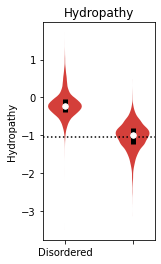

-1.239130434782608 -1.0023148148148142 -0.8026455026455026


In [116]:
Data1 = list([OrderedHydropathy, IDRHydropathy])

#Make a figure
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(2,4))
parts = ax1.violinplot(Data1, showmeans=False, showmedians=False, showextrema=0)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
   # pc.set_edgecolor('black')
    pc.set_alpha(1)
    
ax1.set_title('Hydropathy')
ax1.set_ylabel('Hydropathy')

ax1.set_xticklabels(labels=['Ordered', 'Disordered'])

#Make box and whisker inset
Orderquartile1, Ordermedians, Orderquartile3 = np.percentile(Data1[0], [25, 50, 75])
IDRquartile1, IDRmedians, IDRquartile3 = np.percentile(Data1[1], [25, 50, 75])
Medians = [Ordermedians, IDRmedians]
Quartile1s = [Orderquartile1, IDRquartile1]
Quartile3s = [Orderquartile3, IDRquartile3]
inds = np.arange(1, len(Medians) + 1)
ax1.scatter(inds, Medians, marker='o', color='white', s=30, zorder=3)
ax1.vlines(inds, Quartile1s, Quartile3s, color='k', linestyle='-', lw=5)

ax1.axhline(y=-1.04, color = 'k', linestyle=':') #Average of all initiator hydrophobicity

plt.savefig("Hydropathy.svg")
plt.show()
print(IDRquartile1, IDRmedians, IDRquartile3)

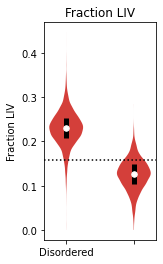

In [117]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

DataLIV = list([OrderedLIV, IDRLIV])

#Make a figure
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(2,4))
parts = ax2.violinplot(DataLIV, showmeans=False, showmedians=False, showextrema=0)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    #pc.set_edgecolor('black')
    pc.set_alpha(1)
    
ax2.set_title('Fraction LIV')
ax2.set_ylabel('Fraction LIV')

ax2.set_xticklabels(labels=['Ordered', 'Disordered'])

#Make box and whisker inset
OrderQ1, OrderMed, OrderQ3 = np.percentile(DataLIV[0], [25, 50, 75])
IDRQ1, IDRMed, IDRQ3 = np.percentile(DataLIV[1], [25, 50, 75])
Medians = [OrderMed, IDRMed]
Q1s = [OrderQ1, IDRQ1]
Q3s = [OrderQ3, IDRQ3]
inds = np.arange(1, len(Medians) + 1)
ax2.scatter(inds, Medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, Q1s, Q3s, color='k', linestyle='-', lw=5)

ax2.axhline(y=0.159, color = 'k', linestyle=':') #Average of all initiator hydrophobicity

plt.savefig("FractionLIV.svg")
plt.show()

In [139]:
#Calculate average sequence composition for initiators, ordered domains, and IDRs
FractionAAIDRs = {'I':[], 'V':[], 'L':[], 'F':[], 'C':[], 'M':[], 'A':[], 'G':[], 'T':[], 'S':[], 'W':[], 'Y':[], 'P':[], 'H':[], 'N':[], 'Q':[], 'D':[], 'E':[], 'K':[], 'R':[]}

for aa in FractionAAIDRs:
    for keys in IDRs:
        for key, value in IDRs[keys].items():
            if len(value) >= 100 and value.count('U') == 0 and value.count('X') == 0:
                FractionAAIDRs[aa].append(value.count(aa)/len(value))
                
AveFracAAIDRs = {'I':[], 'V':[], 'L':[], 'F':[], 'C':[], 'M':[], 'A':[], 'G':[], 'T':[], 'S':[], 'W':[], 'Y':[], 'P':[], 'H':[], 'N':[], 'Q':[], 'D':[], 'E':[], 'K':[], 'R':[]}

for aa in FractionAAIDRs:
    AveFracAAIDRs[aa] = sum(FractionAAIDRs[aa])/len(FractionAAIDRs[aa])                  
                
########################################################
FractionAAOrdered = {'I':[], 'V':[], 'L':[], 'F':[], 'C':[], 'M':[], 'A':[], 'G':[], 'T':[], 'S':[], 'W':[], 'Y':[], 'P':[], 'H':[], 'N':[], 'Q':[], 'D':[], 'E':[], 'K':[], 'R':[]}

for aa in FractionAAOrdered:
    for keys in Ordered:
        for key, value in Ordered[keys].items():
            if len(value) >= 100 and value.count('U') == 0 and value.count('X') == 0:
                FractionAAOrdered[aa].append(value.count(aa)/len(value))
                
AveFracAAOrdered = {'I':[], 'V':[], 'L':[], 'F':[], 'C':[], 'M':[], 'A':[], 'G':[], 'T':[], 'S':[], 'W':[], 'Y':[], 'P':[], 'H':[], 'N':[], 'Q':[], 'D':[], 'E':[], 'K':[], 'R':[]}

for aa in FractionAAOrdered:
    AveFracAAOrdered[aa] = sum(FractionAAOrdered[aa])/len(FractionAAOrdered[aa])              
                
########################################################

FractionAAInitiators = {'I':[], 'V':[], 'L':[], 'F':[], 'C':[], 'M':[], 'A':[], 'G':[], 'T':[], 'S':[], 'W':[], 'Y':[], 'P':[], 'H':[], 'N':[], 'Q':[], 'D':[], 'E':[], 'K':[], 'R':[]}

for aa in FractionAAInitiators:
    for key,value in Initiators.items():
        FractionAAInitiators[aa].append(value.count(aa)/len(value))

AveFracAAInitiators = {'I':[], 'V':[], 'L':[], 'F':[], 'C':[], 'M':[], 'A':[], 'G':[], 'T':[], 'S':[], 'W':[], 'Y':[], 'P':[], 'H':[], 'N':[], 'Q':[], 'D':[], 'E':[], 'K':[], 'R':[]}

for aa in FractionAAInitiators:
    AveFracAAInitiators[aa] = sum(FractionAAInitiators[aa])/len(FractionAAInitiators[aa])
